In [1]:
!pip install -q transformers
# numpy
!pip install -q numpy
# Pillow (แทน PIL)
!pip install  pillow
# datasets (Hugging Face)
!pip install datasets
# transformers + accelerate (สำหรับ Segformer)
!pip install transformers accelerate
# evaluate (สำหรับ metric เช่น mIoU)
!pip install evaluate
# PyTorch (โหลดยางล้อให้เครื่องบิน)
# ถ้าใช้ Colab GPU ปกติ ลองลิงก์ cu121 ก่อน
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch torchvision torchaudio
!pip install -U "transformers>=4.44" "datasets" "evaluate" "accelerate" -q
!pip install -U "transformers>=4.44" "datasets>=2.18" "evaluate>=0.4" "accelerate>=0.33" -q
!pip install matplotlib
!pip install -U hf_transfer -q

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
!pip install -U opencv-python-headless

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
!pip install PyDrive


In [4]:
!pip install --upgrade gdown

import gdown
import os

# File ID ของไฟล์ zip
file_id = "1ndCj8rEXuaQkMhfJWBclEeZAp3cbNwzR"
zip_path = "./unet_dataset.zip"

# ดาวน์โหลดไฟล์ zip
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

# แตกไฟล์ zip
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./unet_dataset")

print("Download and unzip completed! Files are in ./unet_dataset")

Downloading...
From (original): https://drive.google.com/uc?id=1ndCj8rEXuaQkMhfJWBclEeZAp3cbNwzR
From (redirected): https://drive.google.com/uc?id=1ndCj8rEXuaQkMhfJWBclEeZAp3cbNwzR&confirm=t&uuid=ca2a68b4-ca2c-4ffe-8dbc-d8aba69e3047
To: /workspace/unet_dataset.zip
100%|██████████| 2.13G/2.13G [00:15<00:00, 141MB/s] 


Download and unzip completed! Files are in ./unet_dataset


In [5]:
!pip install scikit-learn

In [6]:
import transformers, datasets, evaluate, accelerate
import os

print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("accelerate:", accelerate.__version__)

transformers: 4.57.1
datasets: 4.3.0
evaluate: 0.4.6
accelerate: 1.11.0


In [7]:
# ---------------- Cell 1: paths & pairs ----------------
import os, json
from glob import glob
from PIL import Image
import numpy as np

# ตั้งพาธหลักให้ถูกกับเครื่องคุณ
ROOT = "/workspace/unet_dataset/crack_segmentation_dataset"
OUTPUT_DIR = os.path.join(ROOT, "output_segformer")
os.makedirs(OUTPUT_DIR, exist_ok=True)

TRAIN_IMG_DIR  = os.path.join(ROOT, "train", "images")
TRAIN_MASK_DIR = os.path.join(ROOT, "train", "masks")
TEST_IMG_DIR   = os.path.join(ROOT, "test",  "images")
TEST_MASK_DIR  = os.path.join(ROOT, "test",  "masks")

def list_images(folder):
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files += glob(os.path.join(folder, e))
    return sorted(files)

def normalize_stem(p):
    n = os.path.splitext(os.path.basename(p))[0].lower()
    for suf in ["_mask","-mask",".mask","_gt","-gt","_label","-label","_seg","-seg","_m","-m"]:
        if n.endswith(suf):
            return n[: -len(suf)]
    return n

def build_pairs(img_dir, mask_dir):
    imgs = list_images(img_dir)
    msks = list_images(mask_dir)
    img_map = {normalize_stem(p): p for p in imgs}
    msk_map = {}
    for mp in msks:
        k = normalize_stem(mp)
        if k in msk_map and msk_map[k].lower().endswith(".jpg") and mp.lower().endswith(".png"):
            msk_map[k] = mp
        else:
            msk_map.setdefault(k, mp)
    pairs = []
    for k, ip in img_map.items():
        mp = msk_map.get(k, "")
        pairs.append((ip, mp if mp and os.path.isfile(mp) else ""))
    return pairs

train_pairs = build_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
test_pairs  = build_pairs(TEST_IMG_DIR,  TEST_MASK_DIR)
print(f"train pairs: {len(train_pairs)} | test pairs: {len(test_pairs)}")


train pairs: 9603 | test pairs: 1695


In [8]:
NUM_LABELS   = 2
IGNORE_INDEX = 255
id2label = {0: "background", 1: "defect"}
label2id = {"background": 0, "defect": 1}

# --------- remark --------------
def remap_mask_to_contiguous(arr: np.ndarray) -> np.ndarray:
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    lut = np.full(256, IGNORE_INDEX, dtype=np.uint8)
    lut[0]   = 0
    lut[255] = 1
    return lut[arr].astype(np.int64)


In [9]:
m = np.array(Image.open(train_pairs[0][1]).convert("L"))
mapped = remap_mask_to_contiguous(m)
print(np.unique(mapped))


[  0   1 255]


In [10]:
# ---------------- Cell 3: config ----------------
from dataclasses import dataclass

@dataclass
class CFG:
    root: str = ROOT
    output_dir: str = OUTPUT_DIR
    model_name: str = "nvidia/segformer-b1-finetuned-ade-512-512"
    img_size: int = 512
    batch_size: int = 10
    epochs: int = 2
    lr: float = 5e-5
    weight_decay: float = 1e-4
    seed: int = 42
    ignore_index: int = IGNORE_INDEX

cfg = CFG()
cfg


CFG(root='/workspace/unet_dataset/crack_segmentation_dataset', output_dir='/workspace/unet_dataset/crack_segmentation_dataset/output_segformer', model_name='nvidia/segformer-b1-finetuned-ade-512-512', img_size=512, batch_size=10, epochs=2, lr=5e-05, weight_decay=0.0001, seed=42, ignore_index=255)

In [11]:
# ---------------- Cell 4: processor & model ----------------
import torch
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
processor = AutoImageProcessor.from_pretrained(cfg.model_name)

model = SegformerForSemanticSegmentation.from_pretrained(
    cfg.model_name,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(device)
model.eval(); print("Loaded:", cfg.model_name, "| device:", device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in t

Loaded: nvidia/segformer-b1-finetuned-ade-512-512 | device: cuda


In [12]:
# ---------------- Cell 5: datasets ----------------
from datasets import Dataset, DatasetDict

def to_dataset(pairs):
    return Dataset.from_dict({"image_path":[ip for ip,_ in pairs],
                              "mask_path":[mp for _,mp in pairs]})

ds = DatasetDict({"train": to_dataset(train_pairs),
                  "test":  to_dataset(test_pairs)})

def _load_example(example):
    ip, mp = example["image_path"], example["mask_path"]
    img = Image.open(ip).convert("RGB")
    # เตรียม mask
    if mp and os.path.isfile(mp):
        m = Image.open(mp).convert("L").resize((cfg.img_size, cfg.img_size), Image.NEAREST)
        m = remap_mask_to_contiguous(np.array(m))
    else:
        m = np.zeros((cfg.img_size, cfg.img_size), dtype=np.int64)
    enc = processor(images=img, segmentation_maps=[m], return_tensors="pt")
    return {"pixel_values": enc["pixel_values"][0],
            "labels": enc["labels"][0].long()}

ds = ds.map(_load_example, remove_columns=["image_path","mask_path"])
ds.set_format(type="torch", columns=["pixel_values","labels"])

# def preprocess(example):
#     img = Image.open(example["image_path"]).convert("RGB")
#     mask = Image.open(example["mask_path"]).convert("L").resize((cfg.img_size,cfg.img_size), Image.NEAREST)
#     mask = remap_mask_to_contiguous(np.array(mask))
#     enc = processor(images=img, segmentation_maps=[mask], return_tensors="pt")
#     return {"pixel_values": enc["pixel_values"][0], "labels": enc["labels"][0].long()}

# ds = ds.map(preprocess)

print(ds)


Map:   0%|          | 0/9603 [00:00<?, ? examples/s]

Map:   0%|          | 0/1695 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 9603
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 1695
    })
})


In [13]:
# ---------------- Cell 6: metrics ----------------
import numpy as np
from PIL import Image

def iou_score(pred, target, num_classes, ignore_index=255):
    mask = np.ones_like(target, dtype=bool)
    if ignore_index is not None:
        mask &= (target != ignore_index)
    ious = []
    for c in range(num_classes):
        p = (pred == c) & mask
        t = (target == c) & mask
        inter = np.logical_and(p, t).sum()
        union = np.logical_or(p, t).sum()
        ious.append(inter/union if union else 0.0)
    return np.array(ious), float(np.mean(ious)) if ious else 0.0

def compute_metrics(eval_preds):
    logits, labels = (eval_preds if isinstance(eval_preds, tuple)
                      else (eval_preds.predictions, eval_preds.label_ids))
    preds = logits.argmax(1)
    bs = preds.shape[0]; miou_list = []
    for i in range(bs):
        p = preds[i].astype(np.int32)
        y = labels[i].astype(np.int32)
        # ขนาดไม่เท่า ปรับด้วย PIL แบบ NEAREST
        if y.shape != p.shape:
            y = np.array(Image.fromarray(y).resize((p.shape[1], p.shape[0]), Image.NEAREST))
        _, miou = iou_score(p, y, NUM_LABELS, ignore_index=cfg.ignore_index)
        miou_list.append(miou)
    return {"mIoU": float(np.mean(miou_list))}


In [14]:
# ---------------- Cell 7: training ----------------
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir=cfg.output_dir,
    per_device_train_batch_size=cfg.batch_size,
    per_device_eval_batch_size=cfg.batch_size,
    learning_rate=cfg.lr,
    num_train_epochs=cfg.epochs,
    weight_decay=cfg.weight_decay,
    eval_strategy="epoch",   # ชื่อพารามิเตอร์ที่ถูก
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_total_limit=2,
    report_to=[],
    push_to_hub=False,
    remove_unused_columns=False,
    dataloader_num_workers=2,
    fp16=torch.cuda.is_available(),
    seed=cfg.seed,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=processor,          # ให้ Trainer หยุดบ่น
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model(cfg.output_dir)
processor.save_pretrained(cfg.output_dir)
print(f"[OK] saved to {cfg.output_dir}")


/tmp/ipykernel_3853/4025713759.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Miou
1,0.047900,0.043338,0.705998
2,0.040000,0.039382,0.709891


[OK] saved to /workspace/unet_dataset/crack_segmentation_dataset/output_segformer


In [15]:
# ---------------- Cell 8: inference & save ----------------
import matplotlib.pyplot as plt

SAVE_PRED_DIR    = os.path.join(cfg.output_dir, "pred_masks_test")
SAVE_OVERLAY_DIR = os.path.join(cfg.output_dir, "pred_overlays_test")
os.makedirs(SAVE_PRED_DIR, exist_ok=True)
os.makedirs(SAVE_OVERLAY_DIR, exist_ok=True)

def overlay_multi(img_pil, mask_ids, alpha=0.45):
    img = img_pil.convert("RGBA")
    h, w = mask_ids.shape
    K = int(mask_ids.max()) + 1
    cmap = plt.get_cmap("tab20")
    cols = (cmap(np.linspace(0,1,max(K,2)))[:, :3] * 255).astype(np.uint8)
    ov = np.zeros((h, w, 4), dtype=np.uint8)
    for c in range(1, K):
        m = (mask_ids == c)
        if m.any():
            ov[m,:3] = cols[c]; ov[m,3] = int(255*alpha)
    return Image.alpha_composite(img, Image.fromarray(ov))

@torch.no_grad()
def predict_pil(img_pil):
    x = processor(images=img_pil, return_tensors="pt").to(device)
    logits = model(**x).logits
    H, W = img_pil.size[1], img_pil.size[0]
    if logits.shape[-2:] != (H,W):
        logits = F.interpolate(logits, size=(H,W), mode="bilinear", align_corners=False)
    pred = logits.argmax(1)[0].cpu().numpy().astype(np.uint8)
    return pred

for ip, mp in test_pairs:
    img = Image.open(ip).convert("RGB")
    pred = predict_pil(img)

    base = os.path.splitext(os.path.basename(ip))[0]
    Image.fromarray(pred).save(os.path.join(SAVE_PRED_DIR, f"{base}_pred.png"))
    overlay_multi(img, pred).save(os.path.join(SAVE_OVERLAY_DIR, f"{base}_overlay.png"))

print("Pred masks   ->", SAVE_PRED_DIR)
print("Pred overlay ->", SAVE_OVERLAY_DIR)


Pred masks   -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_masks_test
Pred overlay -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_overlays_test


In [16]:
# ---------------- Cell 9: per-image metrics & summary ----------------
import csv

def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
    if ignore_index is not None:
        mask = (gt != ignore_index)
        gt = gt[mask]; pred = pred[mask]
    idx = gt * num_classes + pred
    return np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)

def metrics_from_cm(cm):
    tp = np.diag(cm); fp = cm.sum(0) - tp; fn = cm.sum(1) - tp
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
    return {"mIoU": float(np.mean(iou)) if len(iou) else 0.0}

cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
csv_path = os.path.join(cfg.output_dir, "metrics_test_per_image.csv")

with open(csv_path, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["image","has_gt","pixels_used","mIoU"])
    for ip, mp in test_pairs:
        base = os.path.splitext(os.path.basename(ip))[0]
        pred = np.array(Image.open(os.path.join(SAVE_PRED_DIR, f"{base}_pred.png")))
        has_gt = bool(mp) and os.path.isfile(mp)
        if has_gt:
            gt_raw = np.array(Image.open(mp).convert("L").resize(pred.shape[::-1], Image.NEAREST))
            gt_ids = remap_mask_to_contiguous(gt_raw)
            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, IGNORE_INDEX)
            cm_total += cm
            mIoU = metrics_from_cm(cm)["mIoU"]
            w.writerow([base, 1, int((gt_ids != IGNORE_INDEX).sum()), f"{mIoU:.4f}"])
        else:
            w.writerow([base, 0, 0, ""])

sum_csv = os.path.join(cfg.output_dir, "metrics_test_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    with open(sum_csv, "w", newline="") as f:
        csv.writer(f).writerows([["mIoU", f"{M['mIoU']:.6f}"]])
    print("Summary ->", sum_csv, "| mIoU =", f"{M['mIoU']:.4f}")
else:
    with open(sum_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note","No GT in test set"])
    print("No GT; wrote note to", sum_csv)


Summary -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/metrics_test_summary.csv | mIoU = 0.7818


PRED_DIR = /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_masks_test
NUM_LABELS: 2 | model.num_labels: 2
CFD_001: classes=[0, 1] counts=[195250, 5454] pos=5454


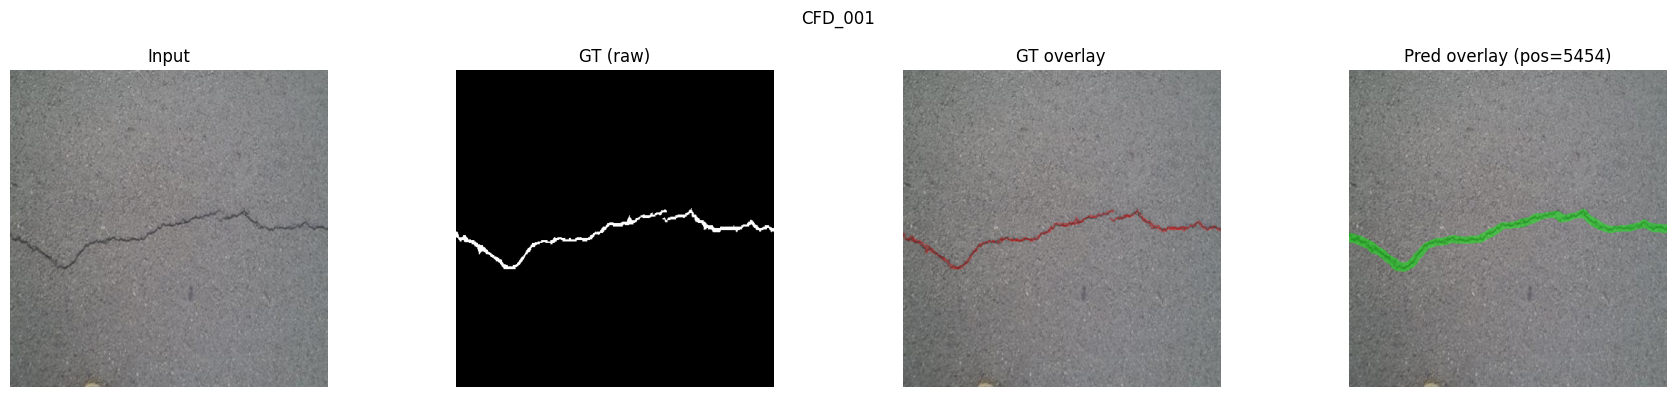

CFD_007: classes=[0, 1] counts=[194423, 6281] pos=6281


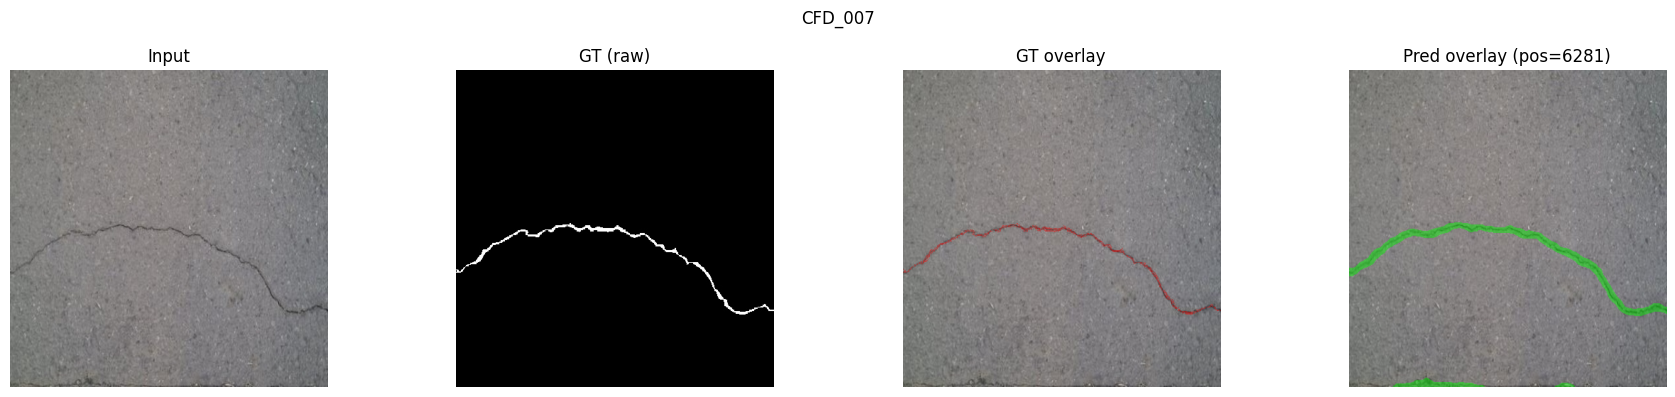

CFD_011: classes=[0, 1] counts=[195284, 5420] pos=5420


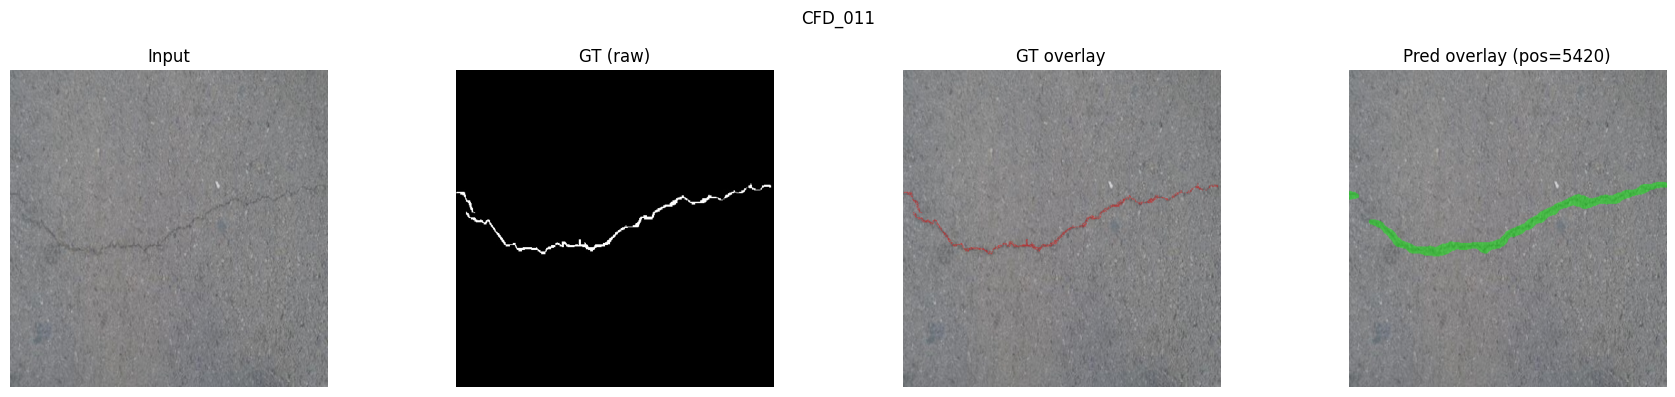

CFD_013: classes=[0, 1] counts=[187488, 13216] pos=13216


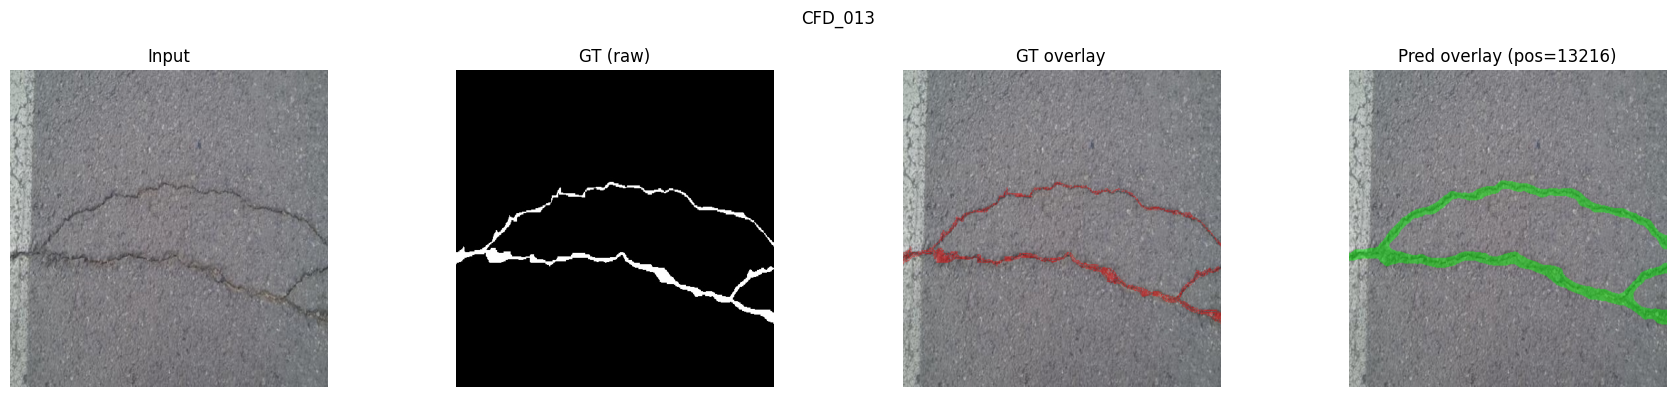

CFD_014: classes=[0, 1] counts=[195393, 5311] pos=5311


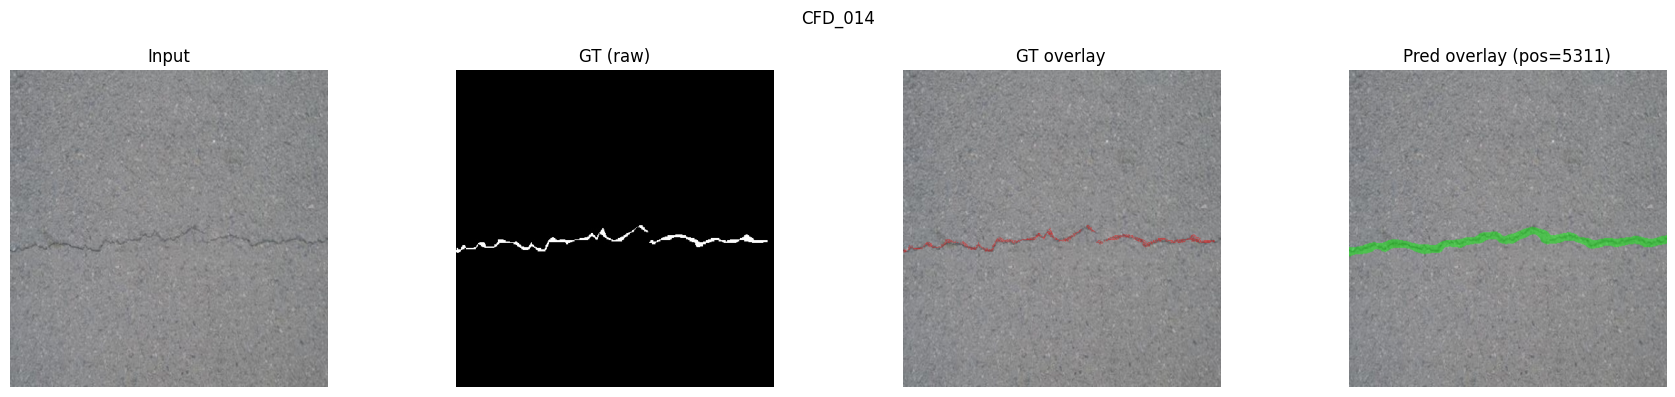

CFD_019: classes=[0, 1] counts=[193413, 7291] pos=7291


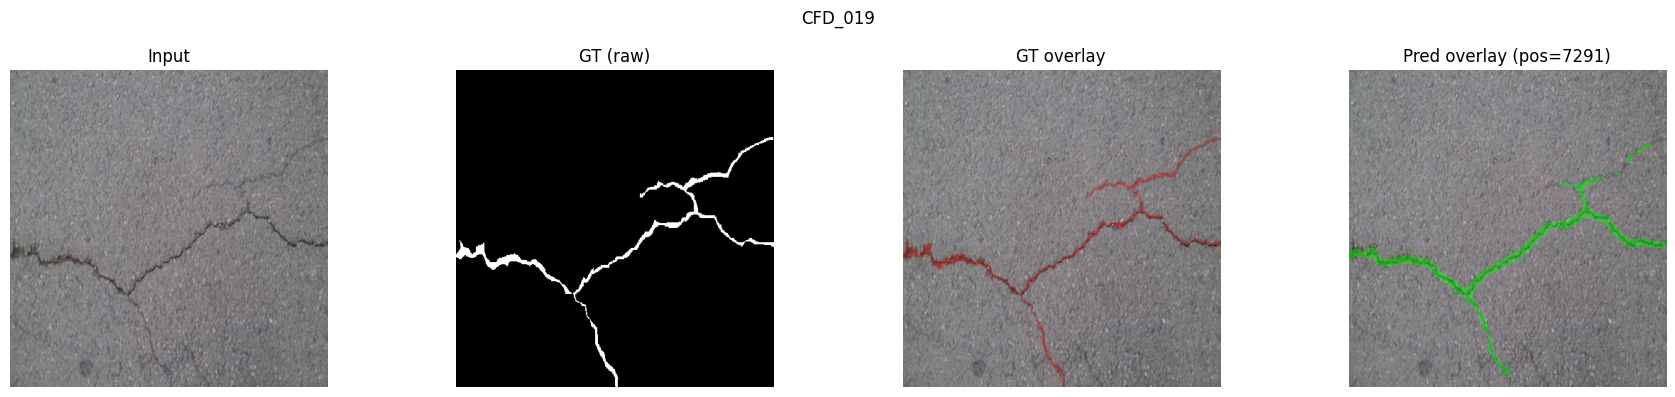

In [17]:
# ---------------- Cell 10 (patched, debug on) ----------------
import matplotlib.pyplot as plt

def overlay_binary(img_pil, mask_bool, color=(0,255,0), alpha=0.50):
    img = img_pil.convert("RGBA")
    h, w = mask_bool.shape
    ov = np.zeros((h,w,4), dtype=np.uint8)
    ov[mask_bool,:3] = color; ov[mask_bool,3] = int(255*alpha)
    return Image.alpha_composite(img, Image.fromarray(ov))

# ถ้าเคยใช้ชื่อโฟลเดอร์อื่น ให้ตั้งตรงนี้ให้ถูก
PRED_DIR = SAVE_PRED_DIR  # หรือ TEST_PRED_DIR ถ้าคุณเซฟไว้ชื่อนั้น
print("PRED_DIR =", PRED_DIR)
print("NUM_LABELS:", NUM_LABELS, "| model.num_labels:", getattr(model.config, "num_labels", None))

SAMPLES_TO_SHOW = 6
for ip, mp in test_pairs[:SAMPLES_TO_SHOW]:
    img  = Image.open(ip).convert("RGB")
    base = os.path.splitext(os.path.basename(ip))[0]
    pred_path = os.path.join(PRED_DIR, f"{base}_pred.png")

    # 1) โหลดจากไฟล์ ถ้าไม่มีให้ predict สด
    if os.path.isfile(pred_path):
        pred_ids = np.array(Image.open(pred_path))
    else:
        pred_ids = predict_pil(img)

    # 2) resize ให้เท่าภาพ
    if pred_ids.shape[::-1] != img.size:
        pred_ids = np.array(Image.fromarray(pred_ids).resize(img.size, Image.NEAREST))

    # 3) DEBUG: ดูคลาสที่ได้จริง
    uniq, cnt = np.unique(pred_ids, return_counts=True)
    print(f"{base}: classes={uniq.tolist()} counts={cnt.tolist()} pos={(pred_ids>0).sum()}")

    # 4) เตรียม GT
    has_gt = bool(mp) and os.path.isfile(mp)
    if has_gt:
        gt_raw_img = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
        gt_ids = remap_mask_to_contiguous(np.array(gt_raw_img))
        gt_bin = (gt_ids == 1) if NUM_LABELS >= 2 else (gt_ids > 0)
        gt_overlay = overlay_binary(img, gt_bin, color=(255,0,0), alpha=0.45)
    else:
        gt_raw_img = None; gt_overlay = None

    # 5) วาด Pred แบบไม่ยึดติดว่าต้องเป็นคลาส 1 เสมอ
    #    ถ้าคุณแน่ใจว่า defect=1 ก็ใช้ (pred_ids==1) ได้
    pred_bin_any = (pred_ids > 0)
    pred_overlay = overlay_binary(img, pred_bin_any, color=(0,255,0), alpha=0.45)

    # 6) plot
    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1); plt.imshow(img); plt.title("Input"); plt.axis("off")
    plt.subplot(1,4,2)
    if gt_raw_img is not None: plt.imshow(gt_raw_img, cmap="gray"); plt.title("GT (raw)")
    else:                       plt.imshow(np.zeros((10,10)));       plt.title("GT: None")
    plt.axis("off")
    plt.subplot(1,4,3)
    if gt_overlay is not None: plt.imshow(gt_overlay); plt.title("GT overlay")
    else:                       plt.imshow(np.zeros((10,10)));       plt.title("GT overlay: None")
    plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(pred_overlay); plt.title(f"Pred overlay (pos={(pred_ids>0).sum()})"); plt.axis("off")
    plt.suptitle(base); plt.tight_layout(); plt.show()


In [38]:
import numpy as np
import pandas as pd

def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
    if ignore_index is not None:
        mask = (gt != ignore_index)
        gt = gt[mask]; pred = pred[mask]
    idx = gt * num_classes + pred
    return np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)

def metrics_from_cm(cm):
    tp = np.diag(cm).astype(np.float64)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.where(tp+fp>0, tp/(tp+fp), 0.0)
        recall    = np.where(tp+fn>0, tp/(tp+fn), 0.0)
        f1        = np.where(precision+recall>0, 2*precision*recall/(precision+recall), 0.0)
        iou       = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
        acc_cls   = np.where((tp+tn+fp+fn)>0, (tp+tn)/(tp+tn+fp+fn), 0.0)

    # ไม่ตัดทศนิยมใดๆ ทั้งสิ้น (ให้เป็น float เต็มๆ)
    macro = {
        "mPrecision": float(np.mean(precision)) if len(precision) else 0.0,
        "mRecall":    float(np.mean(recall))    if len(recall)    else 0.0,
        "mF1":        float(np.mean(f1))        if len(f1)        else 0.0,
        "mIoU":       float(np.mean(iou))       if len(iou)       else 0.0,
        "mAcc":       float(np.mean(acc_cls))   if len(acc_cls)   else 0.0,
    }
    overall_acc = float(tp.sum() / cm.sum()) if cm.sum()>0 else 0.0

    return {
        "per_class": {"precision": precision, "recall": recall, "f1": f1, "iou": iou, "acc": acc_cls},
        "summary":   {**macro, "overall_acc": overall_acc}
    }

# ---------- สร้าง "ตาราง" แล้วพิมพ์ทศนิยมแบบเต็ม ----------
def metrics_table(cm, class_names=None, precision_digits=17):
    res = metrics_from_cm(cm)
    per = res["per_class"]
    df = pd.DataFrame({
        "precision": per["precision"],
        "recall":    per["recall"],
        "f1":        per["f1"],
        "iou":       per["iou"],
        "acc":       per["acc"],
    })
    if class_names:
        df.index = class_names

    # แปลงเป็น string ด้วย precision สูงสุดที่ยังมีสาระ (~16–17 digit)
    fmt = lambda x: np.format_float_positional(float(x), precision=precision_digits, unique=False, trim='k')
    df_str = df.applymap(fmt)

    summ = pd.DataFrame([res["summary"]])
    summ_str = summ.applymap(fmt)

    return df_str, summ_str

# ตัวอย่างใช้งาน:
# df_per_class, df_summary = metrics_table(cm, class_names=[f"class_{i}" for i in range(num_classes)])
# print(df_per_class.to_string())
# print(df_summary.to_string(index=False))


In [41]:
res = metrics_from_cm(cm)
print(res["per_class"]["precision"])   # numpy float array ดิบ
print(res["summary"])                  # dict of floats ดิบ

[1. 0.]
{'mPrecision': 0.5, 'mRecall': 0.5, 'mF1': 0.5, 'mIoU': 0.5, 'mAcc': 1.0, 'overall_acc': 1.0}


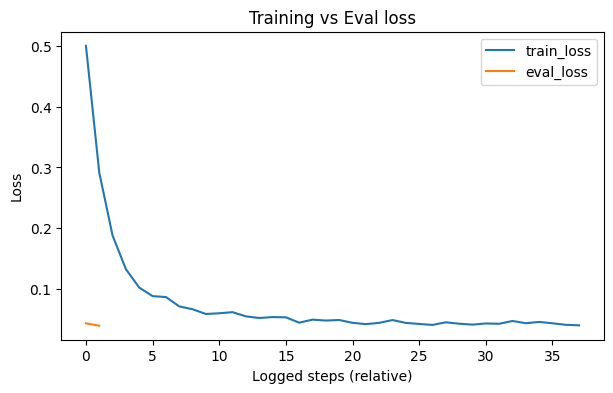

In [19]:
# ===== Plot training/eval losses to spot overfit visually =====
import matplotlib.pyplot as plt

logs = getattr(trainer.state, "log_history", [])
steps, train_loss, eval_loss = [], [], []

for rec in logs:
    if "loss" in rec and "epoch" in rec:  # training step
        steps.append(rec.get("step", len(steps)))
        train_loss.append(rec["loss"])
    if "eval_loss" in rec:
        # eval_loss จะมาจาก eval_dataset ของ Trainer (ของคุณ = ชุด test ที่เอามาเป็น val ชั่วคราว)
        eval_loss.append(rec["eval_loss"])

plt.figure(figsize=(7,4))
plt.plot(train_loss, label="train_loss")
if eval_loss:
    plt.plot(eval_loss, label="eval_loss")
plt.xlabel("Logged steps (relative)"); plt.ylabel("Loss"); plt.title("Training vs Eval loss")
plt.legend(); plt.show()


In [20]:
# ===== Cell B1: Evaluate TRAIN =====
import os, csv, numpy as np
from PIL import Image

# ---- Fallback helpers (ใช้ของเดิมถ้ามี) ----
if 'confusion_from_pair' not in globals():
    def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
        if ignore_index is not None:
            mask = (gt != ignore_index)
            gt = gt[mask]; pred = pred[mask]
        idx = gt * num_classes + pred
        return np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)

if 'metrics_from_cm' not in globals():
    def metrics_from_cm(cm):
        tp = np.diag(cm).astype(np.float64)
        fp = cm.sum(0) - tp
        fn = cm.sum(1) - tp
        tn = cm.sum() - (tp + fp + fn)
        with np.errstate(divide='ignore', invalid='ignore'):
            precision = np.where(tp+fp>0, tp/(tp+fp), 0.0)
            recall    = np.where(tp+fn>0, tp/(tp+fn), 0.0)
            f1        = np.where(precision+recall>0, 2*precision*recall/(precision+recall), 0.0)
            iou       = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
            acc_cls   = np.where((tp+tn+fp+fn)>0, (tp+tn)/(tp+tn+fp+fn), 0.0)
        macro = {
            "mPrecision": float(np.mean(precision)) if len(precision) else 0.0,
            "mRecall":    float(np.mean(recall))    if len(recall)    else 0.0,
            "mF1":        float(np.mean(f1))        if len(f1)        else 0.0,
            "mIoU":       float(np.mean(iou))       if len(iou)       else 0.0,
            "mAcc":       float(np.mean(acc_cls))   if len(acc_cls)   else 0.0,
        }
        overall_acc = float(tp.sum()/cm.sum()) if cm.sum()>0 else 0.0
        return {"per_class": {"precision": precision, "recall": recall, "f1": f1, "iou": iou, "acc": acc_cls},
                "summary":   {**macro, "overall_acc": overall_acc}}

OUT_DIR = cfg.output_dir
os.makedirs(OUT_DIR, exist_ok=True)

cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
per_image_csv = os.path.join(OUT_DIR, "metrics_train_per_image.csv")

with open(per_image_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image","has_gt","pixels_used","mIoU"])
    for ip, mp in train_pairs:
        img = Image.open(ip).convert("RGB")
        pred = predict_pil(img)  # 0..K-1, เท่าขนาดภาพ

        if mp and os.path.isfile(mp):
            gt_raw = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
            gt_ids = remap_mask_to_contiguous(np.array(gt_raw))
            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, IGNORE_INDEX)
            cm_total += cm
            m = metrics_from_cm(cm)
            w.writerow([os.path.basename(ip), 1, int((gt_ids != IGNORE_INDEX).sum()), f"{m['summary']['mIoU']:.4f}"])
        else:
            w.writerow([os.path.basename(ip), 0, 0, ""])

summary_csv = os.path.join(OUT_DIR, "metrics_train_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    with open(summary_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["metric","value"])
        for k,v in M["summary"].items():
            w.writerow([k, f"{v:.6f}"])
    print("[TRAIN] summary:", {k: f"{v:.4f}" for k,v in M["summary"].items()})
else:
    with open(summary_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note","No GT in train set"])
    print("[TRAIN] No GT in train set")

# ---- Train-only risk hint (ยังไม่ตัดสิน overfit จริง) ----
def train_risk_hint(summary_path, high_bar=0.85):
    d = {}
    if os.path.isfile(summary_path):
        for row in csv.reader(open(summary_path, "r")):
            if len(row)==2 and row[0]!="metric":
                try: d[row[0]] = float(row[1])
                except: pass
    tr = d.get("mIoU", None)
    if tr is None: 
        print("[TRAIN] risk: insufficient data")
    elif tr >= high_bar:
        print(f"[TRAIN] risk: very high train mIoU={tr:.3f} (ตรวจ test ต่อเพื่อดู overfit)")
    else:
        print(f"[TRAIN] risk: train mIoU={tr:.3f} (ยังไม่ชี้ชัด ต้องเทียบกับ test)")

train_risk_hint(summary_csv)


[TRAIN] summary: {'mPrecision': '0.8853', 'mRecall': '0.8456', 'mF1': '0.8643', 'mIoU': '0.7839', 'mAcc': '0.9861', 'overall_acc': '0.9861'}
[TRAIN] risk: train mIoU=0.784 (ยังไม่ชี้ชัด ต้องเทียบกับ test)


In [21]:
# ===== Cell B2: Evaluate TEST =====
import os, csv, numpy as np
from PIL import Image

# ใช้ helper จาก B1 ถ้ามีแล้ว

OUT_DIR = cfg.output_dir
os.makedirs(OUT_DIR, exist_ok=True)

cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
per_image_csv = os.path.join(OUT_DIR, "metrics_test_per_image.csv")

with open(per_image_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image","has_gt","pixels_used","mIoU"])
    for ip, mp in test_pairs:
        img = Image.open(ip).convert("RGB")
        pred = predict_pil(img)

        if mp and os.path.isfile(mp):
            gt_raw = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
            gt_ids = remap_mask_to_contiguous(np.array(gt_raw))
            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, IGNORE_INDEX)
            cm_total += cm
            m = metrics_from_cm(cm)
            w.writerow([os.path.basename(ip), 1, int((gt_ids != IGNORE_INDEX).sum()), f"{m['summary']['mIoU']:.4f}"])
        else:
            w.writerow([os.path.basename(ip), 0, 0, ""])

summary_csv = os.path.join(OUT_DIR, "metrics_test_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    with open(summary_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["metric","value"])
        for k,v in M["summary"].items():
            w.writerow([k, f"{v:.6f}"])
    print("[TEST] summary:", {k: f"{v:.4f}" for k,v in M["summary"].items()})
else:
    with open(summary_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note","No GT in test set"])
    print("[TEST] No GT in test set")

# ---- Test-only generalization hint ----
def test_hint(summary_path, ok_bar=0.70):
    d = {}
    if os.path.isfile(summary_path):
        for row in csv.reader(open(summary_path, "r")):
            if len(row)==2 and row[0]!="metric":
                try: d[row[0]] = float(row[1])
                except: pass
    te = d.get("mIoU", None)
    if te is None:
        print("[TEST] hint: insufficient data")
    elif te >= ok_bar:
        print(f"[TEST] hint: mIoU={te:.3f} (generalization พอใช้/ดี)")
    else:
        print(f"[TEST] hint: mIoU={te:.3f} (generalization อ่อน พิจารณาเพิ่ม data/aug/regularization)")

test_hint(summary_csv)


[TEST] summary: {'mPrecision': '0.8853', 'mRecall': '0.8427', 'mF1': '0.8627', 'mIoU': '0.7818', 'mAcc': '0.9859', 'overall_acc': '0.9859'}
[TEST] hint: mIoU=0.782 (generalization พอใช้/ดี)


In [22]:
# ===== Cell C: Compare TRAIN vs TEST and diagnose =====
import os, csv

def load_summary(csv_path):
    d = {}
    if os.path.isfile(csv_path):
        for row in csv.reader(open(csv_path, "r")):
            if len(row)==2 and row[0]!="metric":
                try: d[row[0]] = float(row[1])
                except: pass
    return d

train_sum = load_summary(os.path.join(cfg.output_dir, "metrics_train_summary.csv"))
test_sum  = load_summary(os.path.join(cfg.output_dir, "metrics_test_summary.csv"))
print("[TRAIN] summary:", train_sum)
print("[TEST ] summary:", test_sum)

def diagnose_overfit(train_sum, test_sum, high_bar=0.85, gap_bar=0.10):
    tr = train_sum.get("mIoU", None)
    te = test_sum.get("mIoU",  None)
    if tr is None or te is None:
        return "insufficient_data", "ไม่มี mIoU ครบทั้งสองชุด"

    gap = tr - te
    if tr >= high_bar and gap >= gap_bar:
        return "overfit", f"train mIoU={tr:.3f}, test mIoU={te:.3f}, gap={gap:.3f} (>{gap_bar})"
    if te > tr and (te - tr) >= 0.05:
        return "underfit?", f"test ดีกว่า train: train={tr:.3f}, test={te:.3f}, gap={gap:.3f}"
    return "ok", f"สมดุลดี: train={tr:.3f}, test={te:.3f}, gap={gap:.3f}"

status, note = diagnose_overfit(train_sum, test_sum)
print("[DIAG]", status, "->", note)

# แสดงตัวเลขหลักที่ใช้ตัดสินใจ (ถ้ามี)
for k in ("mPrecision","mRecall","mF1","mIoU","overall_acc"):
    tv = train_sum.get(k, None); sv = test_sum.get(k, None)
    if tv is not None or sv is not None:
        print(f"{k:>12}: train={tv if tv is not None else '-'} | test={sv if sv is not None else '-'}")


[TRAIN] summary: {'mPrecision': 0.885284, 'mRecall': 0.845621, 'mF1': 0.864303, 'mIoU': 0.783889, 'mAcc': 0.986085, 'overall_acc': 0.986085}
[TEST ] summary: {'mPrecision': 0.885299, 'mRecall': 0.842699, 'mF1': 0.862668, 'mIoU': 0.781814, 'mAcc': 0.985901, 'overall_acc': 0.985901}
[DIAG] ok -> สมดุลดี: train=0.784, test=0.782, gap=0.002
  mPrecision: train=0.885284 | test=0.885299
     mRecall: train=0.845621 | test=0.842699
         mF1: train=0.864303 | test=0.862668
        mIoU: train=0.783889 | test=0.781814
 overall_acc: train=0.986085 | test=0.985901


In [24]:
# # ----------------- 10 ------------------------#
# SAVE_PRED_DIR = os.path.join(cfg.output_dir, "pred_masks_test")
# os.makedirs(SAVE_PRED_DIR, exist_ok=True)

# for ip, _ in test_pairs:
#     img = Image.open(ip).convert("RGB")
#     pred = predict_pil(img)
#     out = Image.fromarray((pred>0).astype(np.uint8)*255)  # บันทึกเป็น 0/255
#     base = os.path.splitext(os.path.basename(ip))[0]
#     out.save(os.path.join(SAVE_PRED_DIR, f"{base}_pred.png"))
# print("Saved preds ->", SAVE_PRED_DIR)


In [25]:
# ===================== 13 =======================
# TEST/EVAL PIPELINE (infer + save + metrics)
# - ใช้ได้ทั้ง binary และ multi-class (id ต่อเนื่อง 0..K-1)
# - รองรับ IGNORE_INDEX
# - ไม่พึ่ง cv2 (ใช้ PIL อย่างเดียว)
# - เซฟ: pred_masks_test/, pred_overlays_test/
# - รายภาพ: metrics_test_per_image.csv
# - สรุปรวม: metrics_test_summary.csv
# ต้องมี: test_pairs, cfg.output_dir, model, processor, NUM_LABELS, IGNORE_INDEX
# ถ้ามี class_mapping.json จะโหลดกลับมาใช้ได้อัตโนมัติ
# ============================================
import os, json, csv, numpy as np
from PIL import Image
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

# -------- 0) โหลด mapping ถ้ามี (เผื่อรันใน session ใหม่) --------
mapping_path = os.path.join(cfg.output_dir, "class_mapping.json")
if os.path.isfile(mapping_path):
    with open(mapping_path, "r") as f:
        _mp = json.load(f)
    NUM_LABELS   = _mp.get("NUM_LABELS", NUM_LABELS if "NUM_LABELS" in globals() else None)
    IGNORE_INDEX = _mp.get("IGNORE_INDEX", IGNORE_INDEX if "IGNORE_INDEX" in globals() else 255)
    index2value  = {int(k): int(v) for k,v in _mp.get("index2value", {}).items()}
    value2index  = {int(k): int(v) for k,v in _mp.get("value2index", {}).items()}
else:
    # ถ้าไม่มีไฟล์ ก็ถือว่านายกำหนด NUM_LABELS/IGNORE_INDEX ไว้แล้วจากตอนเทรน
    if "NUM_LABELS" not in globals():
        raise RuntimeError("ไม่พบ NUM_LABELS โปรดกำหนดก่อน หรือให้มี class_mapping.json ใน output_dir")

# -------- 1) helper: รีแมป GT เป็น id ต่อเนื่อง (0..K-1) --------
def remap_mask_to_contiguous(arr: np.ndarray) -> np.ndarray:
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    lut = np.full(256, IGNORE_INDEX, dtype=np.uint16)
    if "value2index" in globals():
        for orig, idx in value2index.items():
            lut[orig] = idx
    else:
        # fallback binary: 0/255 -> 0/1
        lut[:] = IGNORE_INDEX
        lut[0] = 0
        lut[255] = IGNORE_INDEX
        lut[128:255] = 1
    return lut[arr].astype(np.int64)

# -------- 2) predict_pil ถ้ายังไม่มีในสโคป --------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

if "predict_pil" not in globals():
    @torch.no_grad()
    def predict_pil(img_pil: Image.Image) -> np.ndarray:
        x = processor(images=img_pil, return_tensors="pt").to(device)
        logits = model(**x).logits
        H, W = img_pil.size[1], img_pil.size[0]
        if logits.shape[-2:] != (H, W):
            logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
        pred = logits.argmax(1)[0].detach().cpu().numpy().astype(np.int32)  # 0..NUM_LABELS-1
        return pred

# -------- 3) วาด overlay สวยๆ (multi-class สีต่าง, ขอบแดง) --------
def overlay_multi(img_pil, mask_ids, alpha=0.45):
    img = img_pil.convert("RGBA")
    h, w = mask_ids.shape
    K = int(mask_ids.max()) + 1
    cmap = plt.get_cmap("tab20")
    cols = (cmap(np.linspace(0, 1, max(K, 2)))[:, :3] * 255).astype(np.uint8)

    ov = np.zeros((h, w, 4), dtype=np.uint8)
    for c in range(1, K):   # 0 = background
        m = (mask_ids == c)
        if not m.any():
            continue
        ov[m, :3] = cols[c]
        ov[m, 3]  = int(255 * alpha)

    # ขอบแดง
    m = mask_ids
    edge = np.zeros_like(m, dtype=bool)
    edge |= (m != np.roll(m, 1, 0))
    edge |= (m != np.roll(m, -1, 0))
    edge |= (m != np.roll(m, 1, 1))
    edge |= (m != np.roll(m, -1, 1))
    ov[edge, :3] = [255, 0, 0]
    ov[edge, 3]  = 255

    return Image.alpha_composite(img, Image.fromarray(ov))

# -------- 4) metrics helper --------
def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
    if ignore_index is not None:
        mask = (gt != ignore_index)
        gt = gt[mask]; pred = pred[mask]
    idx = gt * num_classes + pred
    cm = np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)
    return cm

def metrics_from_cm(cm):
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.where(tp+fp>0, tp/(tp+fp), 0.0)
        recall    = np.where(tp+fn>0, tp/(tp+fn), 0.0)
        f1        = np.where(precision+recall>0, 2*precision*recall/(precision+recall), 0.0)
        iou       = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
        acc       = np.where((tp+tn+fp+fn)>0, (tp+tn)/(tp+tn+fp+fn), 0.0)

    miou   = float(np.mean(iou)) if len(iou) else 0.0
    mprec  = float(np.mean(precision)) if len(precision) else 0.0
    mrec   = float(np.mean(recall)) if len(recall) else 0.0
    mf1    = float(np.mean(f1)) if len(f1) else 0.0
    oacc   = float(tp.sum()/cm.sum()) if cm.sum()>0 else 0.0

    return {
        "per_class": {
            "precision": precision, "recall": recall, "f1": f1, "iou": iou, "acc": acc
        },
        "summary": {
            "mIoU": miou, "mPrecision": mprec, "mRecall": mrec, "mF1": mf1, "overall_acc": oacc
        }
    }

# -------- 5) เตรียมโฟลเดอร์เอาต์พุต --------
SAVE_PRED_DIR = os.path.join(cfg.output_dir, "pred_masks_test")
SAVE_VIS_DIR  = os.path.join(cfg.output_dir, "pred_overlays_test")
os.makedirs(SAVE_PRED_DIR, exist_ok=True)
os.makedirs(SAVE_VIS_DIR,  exist_ok=True)

# -------- 6) ลูปทดสอบ + เซฟ + เขียน CSV (เปิดไฟล์ครั้งเดียว) --------
cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
csv_path = os.path.join(cfg.output_dir, "metrics_test_per_image.csv")

with open(csv_path, "w", newline="") as fcsv:
    w = csv.writer(fcsv)
    w.writerow(["image", "has_gt", "pixels_used", "mIoU", "mPrecision", "mRecall", "mF1", "overall_acc"])

    for i, (ip, mp) in enumerate(test_pairs, 1):
        img = Image.open(ip).convert("RGB")
        pred = predict_pil(img)  # 0..NUM_LABELS-1, ขนาดเท่าภาพ

        base = os.path.splitext(os.path.basename(ip))[0]

        # เซฟ pred mask เป็น id ต่อเนื่อง (ไม่ใช่ 0/255)
        Image.fromarray(pred.astype(np.uint8)).save(
            os.path.join(SAVE_PRED_DIR, f"{base}_pred.png")
        )

        # ทำ overlay แล้วเซฟ
        overlay_multi(img, pred, alpha=0.45).save(
            os.path.join(SAVE_VIS_DIR, f"{base}_overlay.png")
        )

        # GT ถ้ามี
        has_gt = bool(mp) and os.path.isfile(mp)
        if has_gt:
            gt_raw = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
            gt_arr = np.array(gt_raw)
            gt_ids = remap_mask_to_contiguous(gt_arr)  # map เป็น id ต่อเนื่อง

            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, ignore_index=IGNORE_INDEX)
            cm_total += cm
            m = metrics_from_cm(cm)

            w.writerow([
                base, 1, int((gt_ids != IGNORE_INDEX).sum()),
                f"{m['summary']['mIoU']:.4f}",
                f"{m['summary']['mPrecision']:.4f}",
                f"{m['summary']['mRecall']:.4f}",
                f"{m['summary']['mF1']:.4f}",
                f"{m['summary']['overall_acc']:.4f}",
            ])
        else:
            w.writerow([base, 0, 0, "", "", "", "", ""])

print(f"Saved pred masks   -> {SAVE_PRED_DIR}")
print(f"Saved pred overlays-> {SAVE_VIS_DIR}")
print(f"Per-image metrics  -> {csv_path}")

# -------- 7) สรุปรวมชุด test --------
sum_csv = os.path.join(cfg.output_dir, "metrics_test_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    print("\n=== Test summary ===")
    for k, v in M["summary"].items():
        print(f"{k:>12}: {v:.4f}")

    with open(sum_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["metric", "value"])
        for k, v in M["summary"].items():
            w.writerow([k, f"{v:.6f}"])
    print("Saved test summary ->", sum_csv)
else:
    with open(sum_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note", "No GT available; skipped aggregate metrics"])
    print("No GT on test set; wrote note to", sum_csv)


Saved pred masks   -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_masks_test
Saved pred overlays-> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_overlays_test
Per-image metrics  -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/metrics_test_per_image.csv

=== Test summary ===
        mIoU: 0.6638
  mPrecision: 0.7217
     mRecall: 0.7857
         mF1: 0.7496
 overall_acc: 0.9911
Saved test summary -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/metrics_test_summary.csv


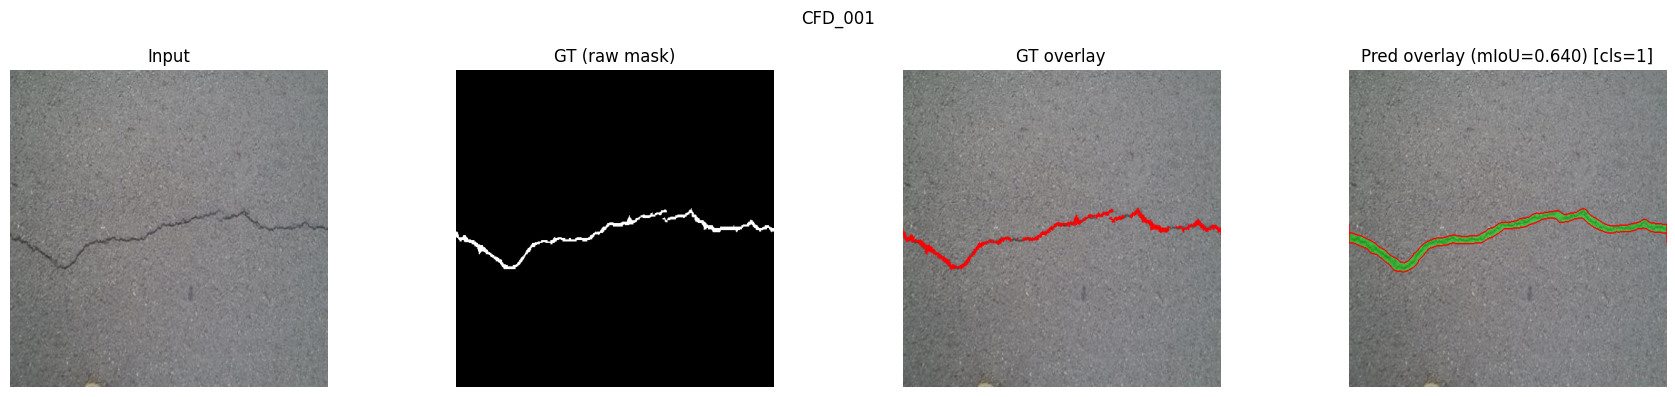

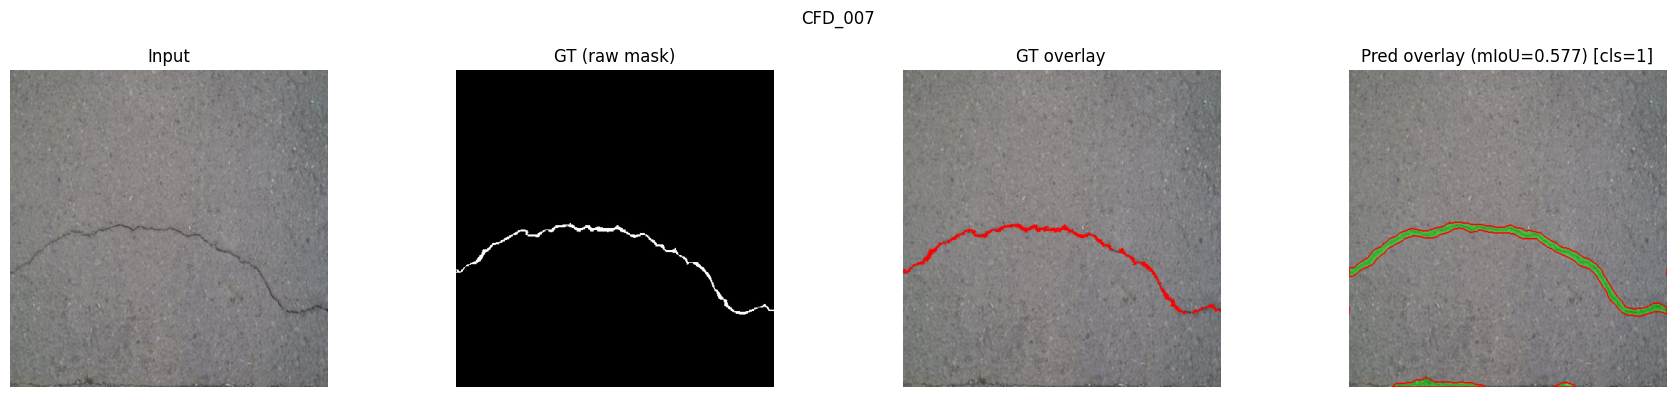

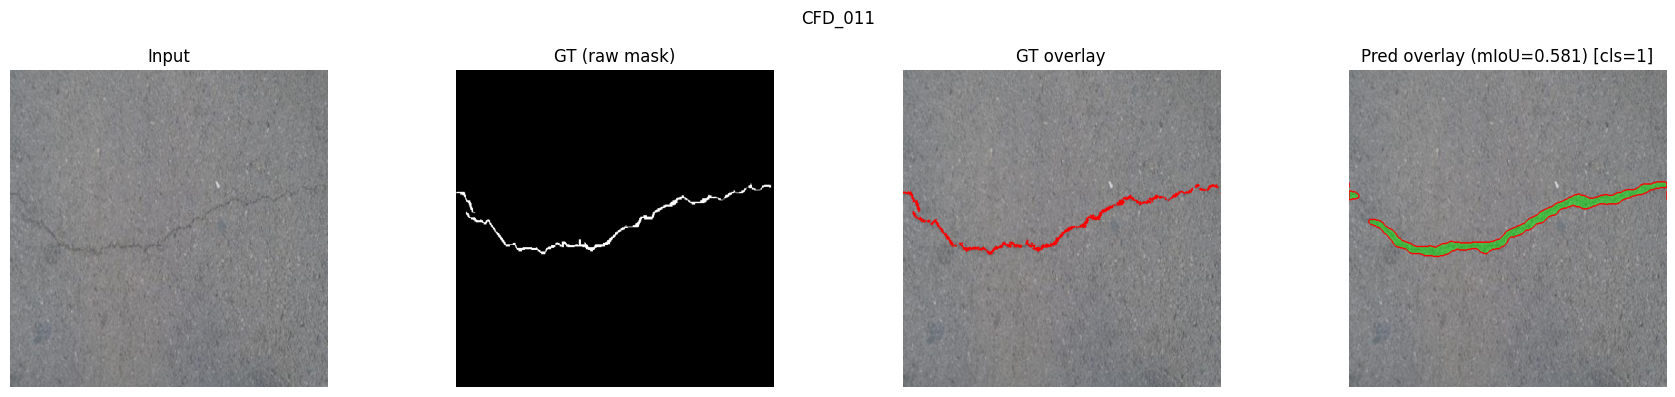

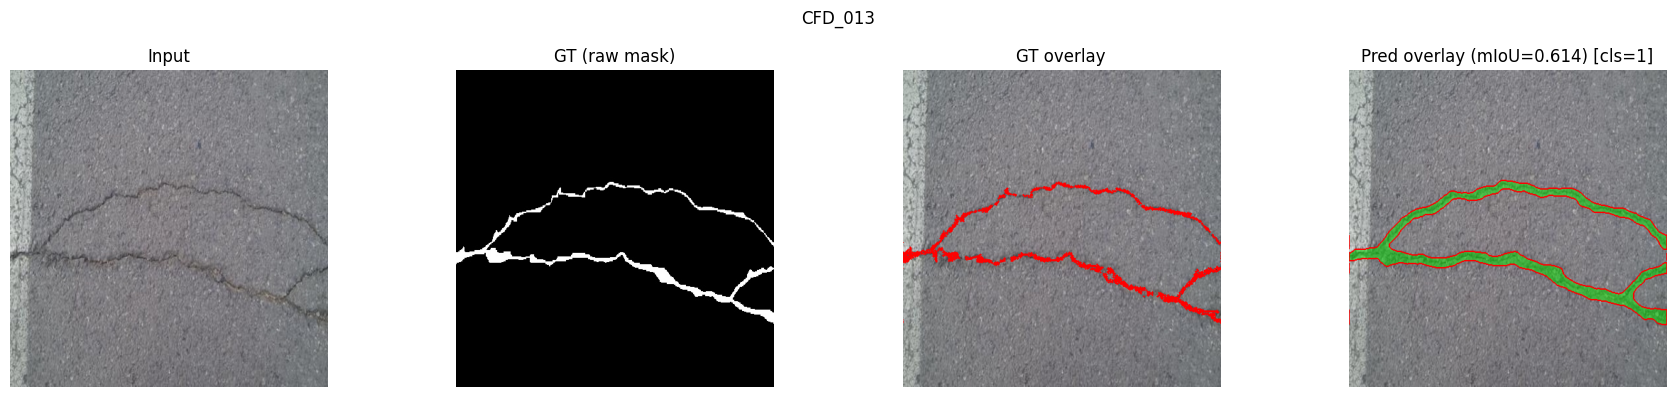

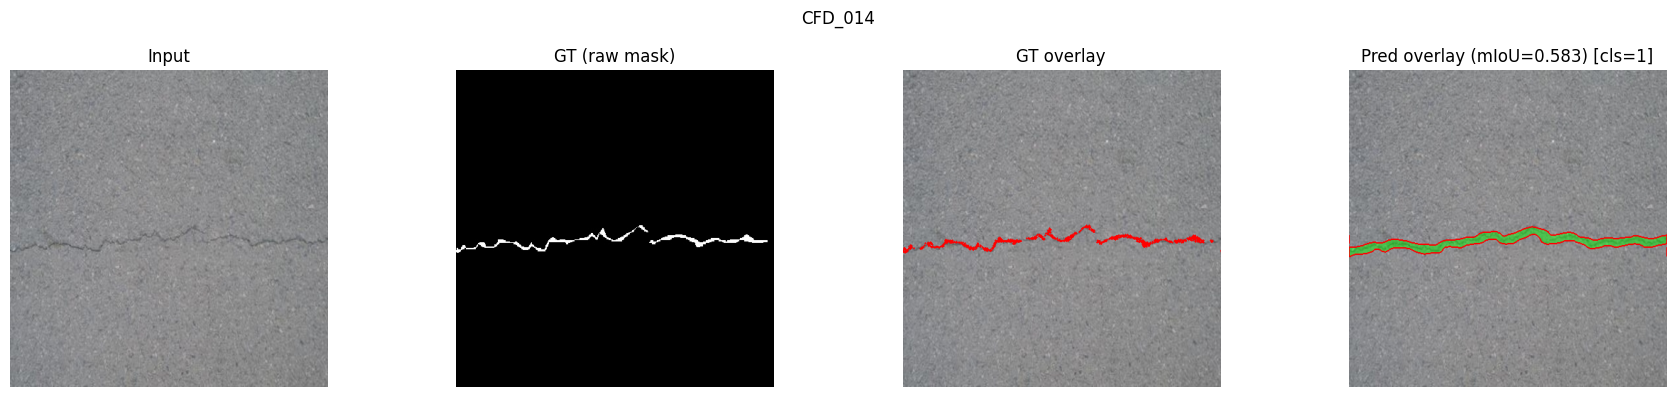

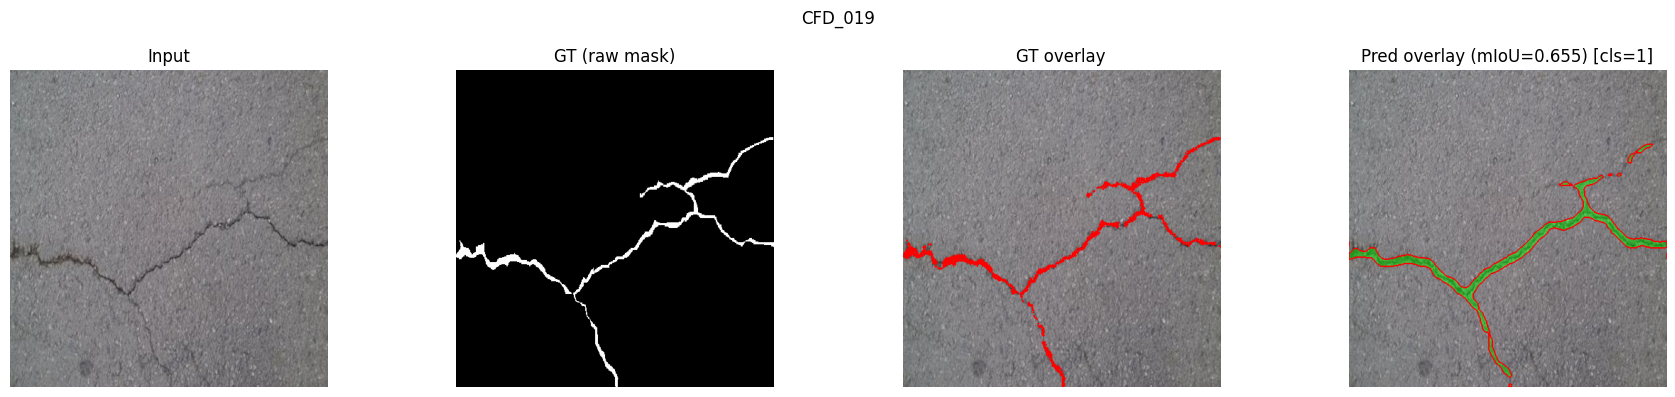

In [26]:
# ----------------------------- 14 ---------------------------------- #
# ================== SHOW GT & PRED (RAW + OVERLAY) ==================
# ต้องมีตัวแปรมาก่อน: test_pairs, SAVE_PRED_DIR
# ตัวเลือกเสริม (มีหรือไม่มีก็ได้): NUM_LABELS, IGNORE_INDEX, id2label, remap_mask_to_contiguous, iou_score
# - pred ที่เซฟไว้คือไฟล์ <name>_pred.png เป็น "class id map" (0..K-1) ตามโค้ดทดสอบก่อนหน้า

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---------- helpers ----------
def overlay_multi(img_pil, mask_ids, alpha=0.45, edge_color=(255,0,0)):
    img = img_pil.convert("RGBA")
    h, w = mask_ids.shape
    K = int(mask_ids.max()) + 1
    cmap = plt.get_cmap("tab20")
    cols = (cmap(np.linspace(0, 1, max(K, 2)))[:, :3] * 255).astype(np.uint8)

    ov = np.zeros((h, w, 4), dtype=np.uint8)
    for c in range(1, K):   # 0 = background
        m = (mask_ids == c)
        if not m.any():
            continue
        ov[m, :3] = cols[c]
        ov[m, 3]  = int(255 * alpha)

    # edge ให้เด่น
    m = mask_ids
    edge = np.zeros_like(m, dtype=bool)
    edge |= (m != np.roll(m, 1, 0))
    edge |= (m != np.roll(m, -1, 0))
    edge |= (m != np.roll(m, 1, 1))
    edge |= (m != np.roll(m, -1, 1))
    ov[edge, :3] = edge_color
    ov[edge, 3]  = 255

    return Image.alpha_composite(img, Image.fromarray(ov))

def overlay_binary(img_pil, mask_bool, color=(0,255,0), alpha=0.45, edge_color=(255,0,0)):
    img = img_pil.convert("RGBA")
    h, w = mask_bool.shape
    ov = np.zeros((h, w, 4), dtype=np.uint8)
    ov[mask_bool, :3] = color
    ov[mask_bool, 3]  = int(255 * alpha)

    m = mask_bool.astype(np.uint8)
    edge = np.zeros_like(m, dtype=bool)
    edge |= (m != np.roll(m, 1, 0))
    edge |= (m != np.roll(m, -1, 0))
    edge |= (m != np.roll(m, 1, 1))
    edge |= (m != np.roll(m, -1, 1))
    ov[edge, :3] = edge_color
    ov[edge, 3]  = 255

    return Image.alpha_composite(img, Image.fromarray(ov))

def per_class_iou(pred_ids, gt_ids, num_classes, ignore_index=None):
    mask = (gt_ids != ignore_index) if ignore_index is not None else np.ones_like(gt_ids, bool)
    ious = []
    for c in range(num_classes):
        if ignore_index is not None and c == ignore_index:
            ious.append(0.0); continue
        p = (pred_ids == c) & mask
        g = (gt_ids  == c) & mask
        inter = np.logical_and(p, g).sum()
        union = np.logical_or(p, g).sum()
        ious.append(inter / union if union else 0.0)
    return np.array(ious, dtype=np.float64)

# ---------- config ----------
PRED_DIR   = SAVE_PRED_DIR
SAMPLES    = test_pairs[:6]           # ปรับจำนวนตัวอย่างที่อยากดู
BG_CLASS   = 0                        # พื้นหลัง
DEFECT_CANDIDATE_NAME = "defect"      # ถ้ามี id2label จะพยายามใช้คลาสนี้ก่อน

# ---------- main loop ----------
for ip, mp in SAMPLES:
    base = os.path.splitext(os.path.basename(ip))[0]
    pred_path = os.path.join(PRED_DIR, f"{base}_pred.png")
    if not os.path.isfile(pred_path):
        continue

    # ภาพจริง
    img = Image.open(ip).convert("RGB")

    # โหลด pred เป็น "id map" ตรงๆ (ห้าม threshold 128)
    pred_ids = np.array(Image.open(pred_path))  # uint8 0..K-1
    if pred_ids.shape[::-1] != img.size:
        pred_ids = np.array(Image.fromarray(pred_ids).resize(img.size, Image.NEAREST))

    # โหลด GT "ดิบจากไฟล์" เพื่อแสดง grayscale
    has_gt = bool(mp) and os.path.isfile(mp)
    if has_gt:
        gt_raw_img = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)  # raw mask for display
        gt_raw_arr = np.array(gt_raw_img)

        # รีแมปเป็น id ต่อเนื่องสำหรับคำนวณ/overlay
        if "remap_mask_to_contiguous" in globals():
            gt_ids = remap_mask_to_contiguous(gt_raw_arr)
        else:
            # fallback binary: 0/255 -> 0/1, อื่นๆเป็น ignore
            ig = 255 if "IGNORE_INDEX" in globals() else 255
            lut = np.full(256, ig, dtype=np.uint8)
            lut[0]   = 0
            lut[128:]= 1
            gt_ids = lut[gt_raw_arr]

        # กำหนด NUM_LABELS/IGNORE_INDEX ถ้าไม่มี
        if "NUM_LABELS" not in globals():
            NUM_LABELS = int(max(pred_ids.max(), gt_ids.max()) + 1)
        if "IGNORE_INDEX" not in globals():
            IGNORE_INDEX = 255

        # เลือกคลาสสำหรับทำ binary overlay ให้ดู
        choose_cls = None
        if "id2label" in globals() and isinstance(id2label, dict):
            for k, v in id2label.items():
                if str(v).lower() == DEFECT_CANDIDATE_NAME:
                    choose_cls = int(k); break
        if choose_cls is None:
            ious = per_class_iou(pred_ids, gt_ids, NUM_LABELS, IGNORE_INDEX)
            # ตัดพื้นหลังออก แล้วเลือก IoU สูงสุดที่ > 0 ถ้ามี ไม่งั้นก็เลือก 1
            cand = [(i, ious[i]) for i in range(NUM_LABELS) if i != BG_CLASS]
            choose_cls = max(cand, key=lambda t: t[1])[0] if cand else 1

        pred_bin = (pred_ids == choose_cls)
        gt_bin   = (gt_ids  == choose_cls)

        # คำนวณ mIoU รวม ถ้ามี iou_score ใช้มัน ไม่งั้นใช้ค่าเฉลี่ย per-class
        if "iou_score" in globals():
            _, miou = iou_score(pred_ids.astype(np.int32), gt_ids.astype(np.int32),
                                NUM_LABELS, ignore_index=IGNORE_INDEX)
        else:
            miou = float(per_class_iou(pred_ids, gt_ids, NUM_LABELS, IGNORE_INDEX).mean())
        title_right = f"Pred overlay (mIoU={miou:.3f}) [cls={choose_cls}]"

    else:
        gt_raw_img = None
        pred_bin   = (pred_ids > 0)
        title_right= "Pred overlay (all>0)"

    # ---------- plot 4 ช่อง: Input | GT raw | GT overlay | Pred overlay ----------
    plt.figure(figsize=(18, 4))

    plt.subplot(1,4,1)
    plt.imshow(img); plt.title("Input"); plt.axis("off")

    plt.subplot(1,4,2)
    if gt_raw_img is not None:
        # โชว์ "mask จริงจากไฟล์" แบบ grayscale ตามที่นายขอ
        plt.imshow(gt_raw_img, cmap="gray")
        plt.title("GT (raw mask)")
    else:
        plt.imshow(np.zeros((10,10))); plt.title("GT: None")
    plt.axis("off")

    plt.subplot(1,4,3)
    if has_gt:
        plt.imshow(overlay_binary(img, gt_bin, color=(255,0,0), alpha=0.45))
        plt.title("GT overlay")
    else:
        plt.imshow(np.zeros((10,10))); plt.title("GT overlay: None")
    plt.axis("off")

    plt.subplot(1,4,4)
    if pred_ids.max() > 1:
        # ถ้ามีหลายคลาสและอยากเห็นทุกสี ใช้ overlay_multi(pred_ids)
        # แต่ที่นี่ให้ดู binary class ที่เลือกไว้
        plt.imshow(overlay_binary(img, pred_bin, color=(0,255,0), alpha=0.45))
    else:
        plt.imshow(overlay_binary(img, pred_bin, color=(0,255,0), alpha=0.45))
    plt.title(title_right); plt.axis("off")

    plt.suptitle(base)
    plt.tight_layout()
    plt.show()